In [ ]:
!nvidia-smi

Fri Dec  6 00:27:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import necessary packages and libraries


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version 2.5.1+cu121
Torchvision version 0.20.1+cu121
Numpy version 1.26.4
Pandas version 2.2.2


# Setting up dataset and dataloader to wrap the dataset


1.   Defining class for GalaxyImageDataset
2.   Uploading dataset in google drive
3.   Create example/test dataset and dataloader
      - Run some commands and output to test functionality
4.   Set up training, validation, and test datasets and dataloaders


In [ ]:
class GalaxyImageDataset (Dataset) :
  def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):
        return self.data[idx]

  @property
  def classes(self):
        return self.data.classes


In [ ]:
# upload the datset into my google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# unzip the dataset zip file
!unzip -q '/content/drive/My Drive/Datasets/images_E_S_SB_227x227_a_03.zip' -d '/content/dataset'

In [ ]:
data_dir = '/content/dataset/images_E_S_SB_227x227_a_03_train'
dataset = GalaxyImageDataset(data_dir = data_dir);

In [ ]:
len(dataset)

120432

0


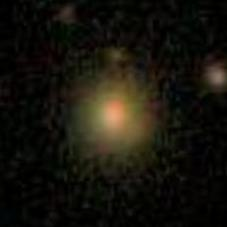

In [ ]:
image, label = dataset[0]
print(label)
image

In [ ]:
# maps each label(number) to the corresponding galaxy "classification"
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'E', 1: 'S', 2: 'SB'}


In [ ]:
# defining our transform function for the images
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

# "test" dataset to ensure it works correctly
data_dir = '/content/dataset/images_E_S_SB_227x227_a_03_train'
dataset = GalaxyImageDataset(data_dir = data_dir, transform=transform)

In [ ]:
image, label = dataset[100]
# every image has been transformed into a tensor(3 represents RGB, 227x227 represents size)
image.shape

torch.Size([3, 227, 227])

In [ ]:
for image, label in dataset:
    break
print("Label for current image: ", label)
print("Corresponding class: ", target_to_class[label])

Label for current image:  0
Corresponding class:  E


In [ ]:
# load in our dataset into dataloader
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [ ]:
#iterate over dataloader
for images, labels in dataloader:
    break

images.shape, labels.shape


(torch.Size([32, 3, 227, 227]), torch.Size([32]))

In [ ]:
# labels are also shuffled
labels

tensor([0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0])

In [ ]:
train_data_dir = '/content/dataset/images_E_S_SB_227x227_a_03_train'
test_data_dir = '/content/dataset/images_E_S_SB_227x227_a_03_test'

train_dataset = GalaxyImageDataset(data_dir = train_data_dir, transform = transform)
val_dataset = GalaxyImageDataset(data_dir = train_data_dir, transform = transform)
test_dataset = GalaxyImageDataset(data_dir = test_data_dir, transform=transform)

# dataset is split into 90% training and 10% test
# will split training dataset(called dataset) into 90% training and 10% validation
# thus final split will be: 81% training, 9% validation, 10% test
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
#extract our labels
labels = [train_dataset[i][1] for i in range(len(train_dataset))]
print(len(labels))


train_indices, val_indices = train_test_split(indices, test_size=0.1, stratify = labels, random_state=42)

# create subsets for training and validation
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

#print lengths of each subset
print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_dataset)}")


# load in our training, validation, and test data
train_loader = DataLoader(train_subset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_subset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

120432
Training set size: 108388
Validation set size: 12044
Test set size: 13380


# Creating our Deep Learning Model


1.   Utilizing a predefined, pretrained CNN 'efficientnet_b0'
2.   Comes from the timm library of models
3.   Initialize model with 3 classes representing each galaxy classification(E, S, SB)




In [ ]:
class GalaxyImageClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(GalaxyImageClassifier, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        # removing the last layer of the model
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)


    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
       # x = x.view(x.size(0), -1)
        output = self.classifier(x)
        return output


In [ ]:
model = GalaxyImageClassifier(num_classes = 3)
print(str(model) [:500])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

GalaxyImageClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=F


In [ ]:
# check if model takes in input properly
example_output = model(images)
print(example_output)
example_output.shape # [batch_size, num_classes]

tensor([[-0.2364,  0.0677, -0.1403],
        [ 0.0511, -0.0629, -0.1824],
        [ 0.0734, -0.1196, -0.1131],
        [ 0.2841, -0.0357,  0.0932],
        [-0.0181, -0.1747, -0.0736],
        [-0.0585, -0.1504, -0.2863],
        [-0.1279, -0.0230, -0.2015],
        [-0.1883, -0.0778, -0.1884],
        [ 0.2169,  0.0113, -0.0677],
        [-0.4244, -0.0587, -0.0363],
        [-0.0099, -0.0327, -0.0947],
        [-0.2030, -0.1563, -0.0779],
        [-0.0766, -0.1623, -0.2621],
        [ 0.0825, -0.4075, -0.1870],
        [-0.0577, -0.3619,  0.0779],
        [-0.0730, -0.0164, -0.0862],
        [-0.0866, -0.0392, -0.1919],
        [ 0.0053,  0.0445, -0.1011],
        [ 0.0120, -0.2246, -0.0856],
        [ 0.0645, -0.0569, -0.0466],
        [ 0.1052, -0.1618,  0.0916],
        [ 0.0304, -0.0492,  0.0248],
        [-0.1831, -0.2591, -0.1976],
        [ 0.0472, -0.0259, -0.0807],
        [-0.0537, -0.1192, -0.2410],
        [-0.1051, -0.0120, -0.0996],
        [-0.0900,  0.0366, -0.2860],
 

torch.Size([32, 3])

Create loss function - quantifies error between predicted(model) and actual values

Create optimizer function with weight decay and learning rate of 0.001, works by adjusting model parameters/weights to minimize this loss




In [ ]:
# create a training loop
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-5);

In [ ]:
criterion(example_output, labels)

tensor(1.1084, grad_fn=<NllLossBackward0>)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Training Loop

In [ ]:
# an epoch is one run through the entire dataset
num_epochs = 5;
train_losses = []
val_losses = []

model = GalaxyImageClassifier(num_classes = 3)
model.to(device)

#define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-5)


for epoch in range(num_epochs):
  # set the model to train
  model.train()
  running_loss = 0.0
  # tqdm allows us to see a progress bar
  for images, labels in tqdm(train_loader, desc = "Training loop"):
    # move the inputs and outputs to the device
    images, labels = images.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    # Computes the gradients of the loss with respect to the model parameters through backpropagation. This prepares the model for a parameter update in the next step.
    loss.backward()
    # updates models parameters based on computed gradients, where model actually "learns" to reduce loss
    optimizer.step()
    running_loss += loss.item() * labels.size(0)
  # calculates the average loss for the current epoch
  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

  # validation phase
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
  val_loss = running_loss / len(val_loader.dataset)
  val_losses.append(val_loss)

  print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Training loop:   0%|          | 0/3388 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.4472, Validation loss: 0.3865


Training loop:   0%|          | 0/3388 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.3951, Validation loss: 0.3745


Training loop:   0%|          | 0/3388 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.3779, Validation loss: 0.3734


Training loop:   0%|          | 0/3388 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.3649, Validation loss: 0.3791


Training loop:   0%|          | 0/3388 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/377 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.3553, Validation loss: 0.3635


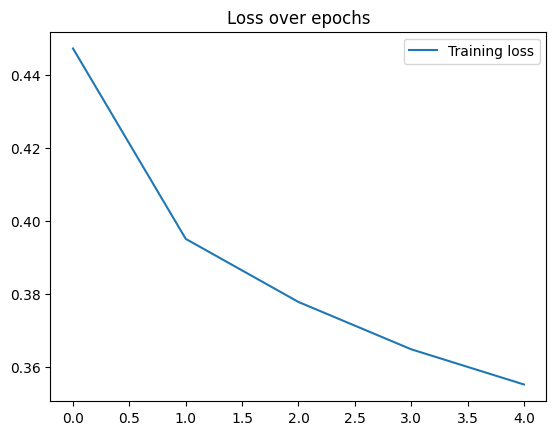

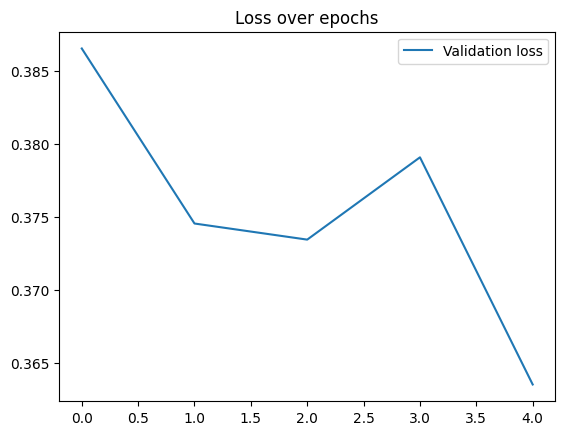

In [ ]:
# visualize data
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Evaluate

*   How well does our model classify the galaxy in the images?
*   Define prediction and visualize functions to show probabilities of each category predicted



In [ ]:
# evaluate our results using a prediction function
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

def extract_label_from_path(image_path):
    # Extract the parent folder name as the label
    label_name = os.path.basename(os.path.dirname(image_path))
    return label_name

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        # converts the raw data from our model(logits) into a probability distribution across classes
        # uses sotftmax function
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        # converts probabilities tensor into a numpy array
    return probabilities.cpu().numpy().flatten()

# display results
def visualize_predictions(original_image, probabilities, class_names, true_label = None):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    # Add the true label to the image title
    if true_label is not None:
      axarr[0].set_title(f"True Label: {true_label}", fontsize=14)
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

E


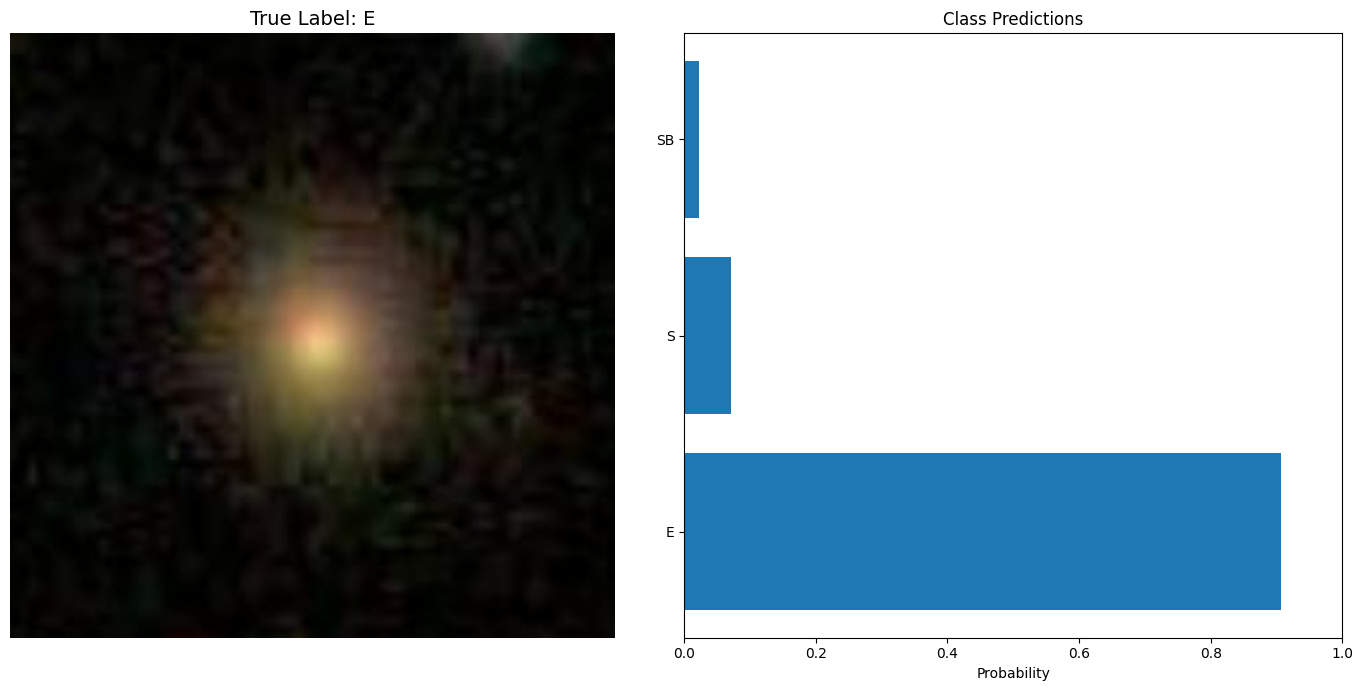

In [ ]:
# use an example image/images to test the model
test_image_path = '/content/dataset/images_E_S_SB_227x227_a_03_test/E/655.jpg'
true_label = extract_label_from_path(test_image_path) # should be 'E' in this case
print(true_label)

transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])
original_image, image_tensor = preprocess_image(test_image_path, transform)
probabilities = predict(model, image_tensor, device)

class_names = list(target_to_class.values())
# visualize the probabilities for each class(E, S, SB) to see how well model predicts
visualize_predictions(original_image, probabilities, class_names, true_label)

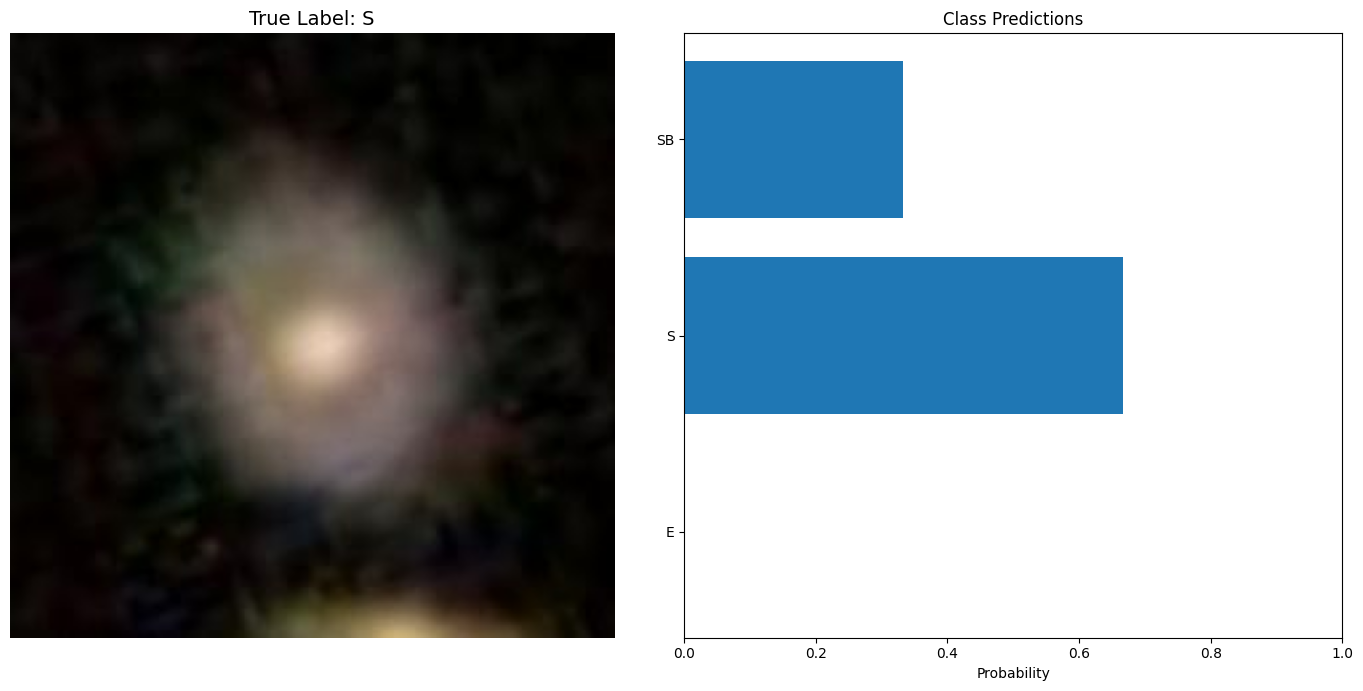

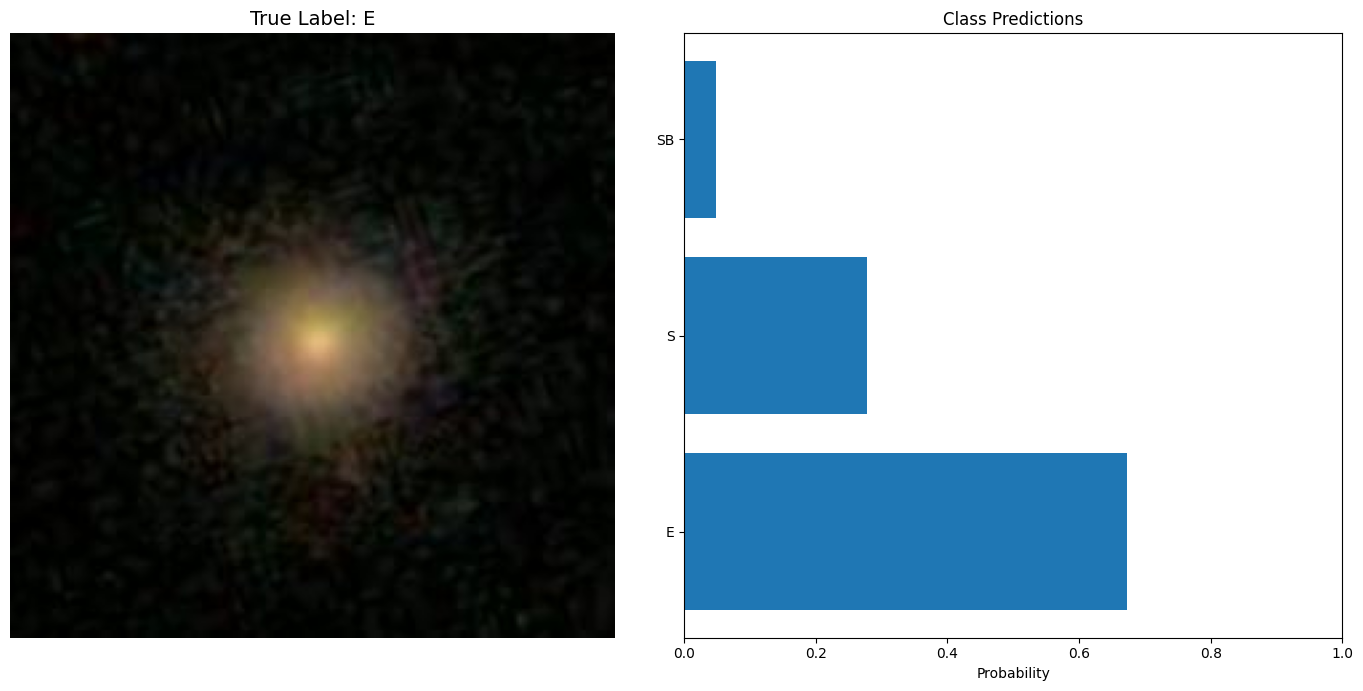

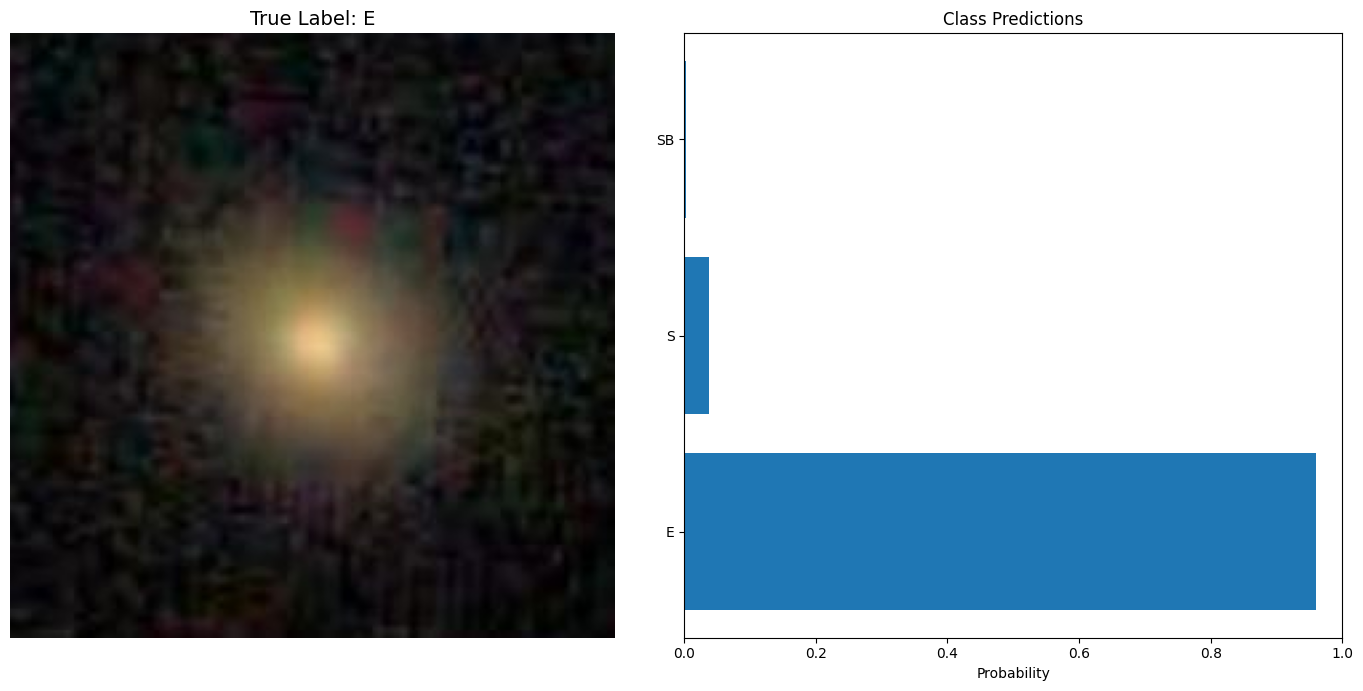

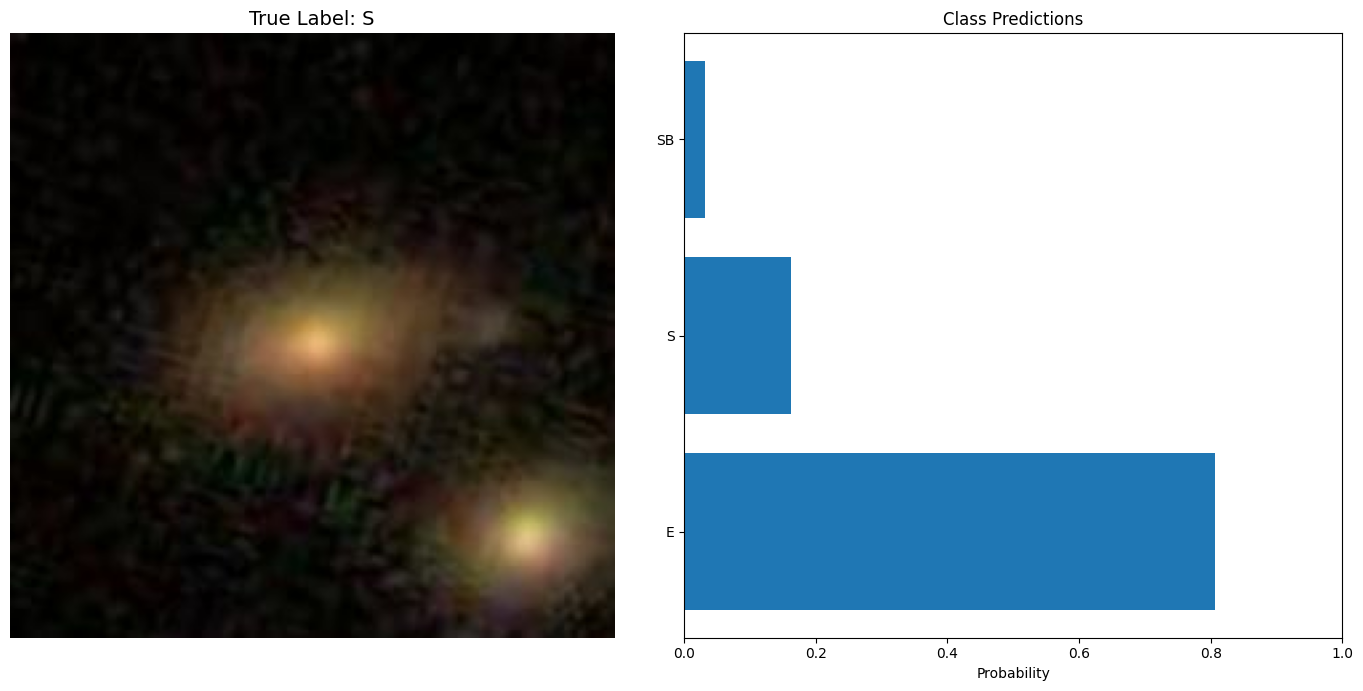

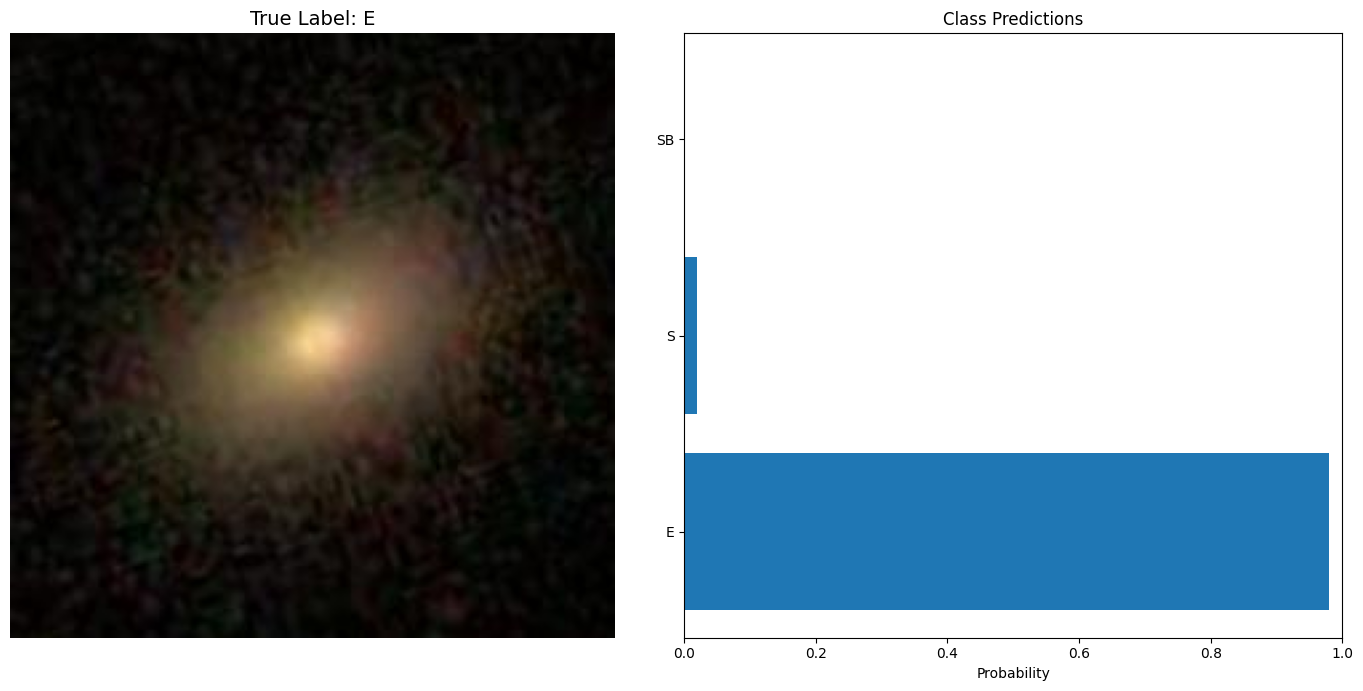

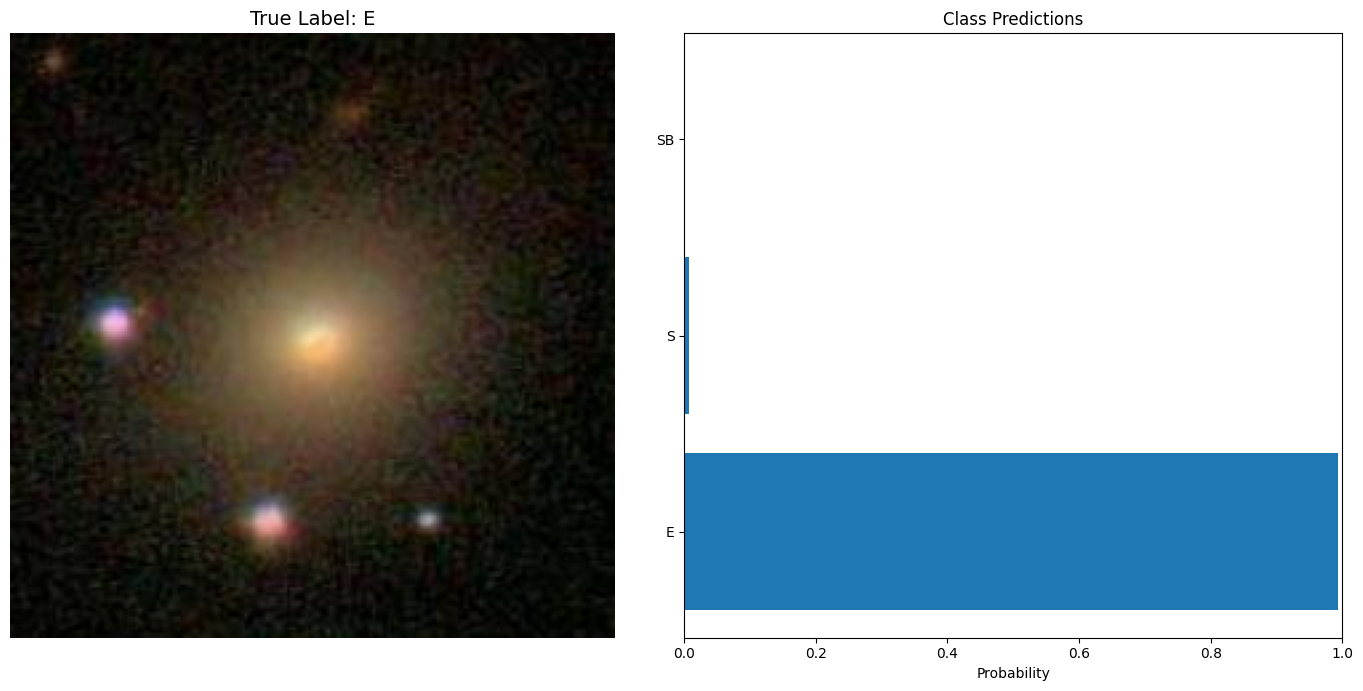

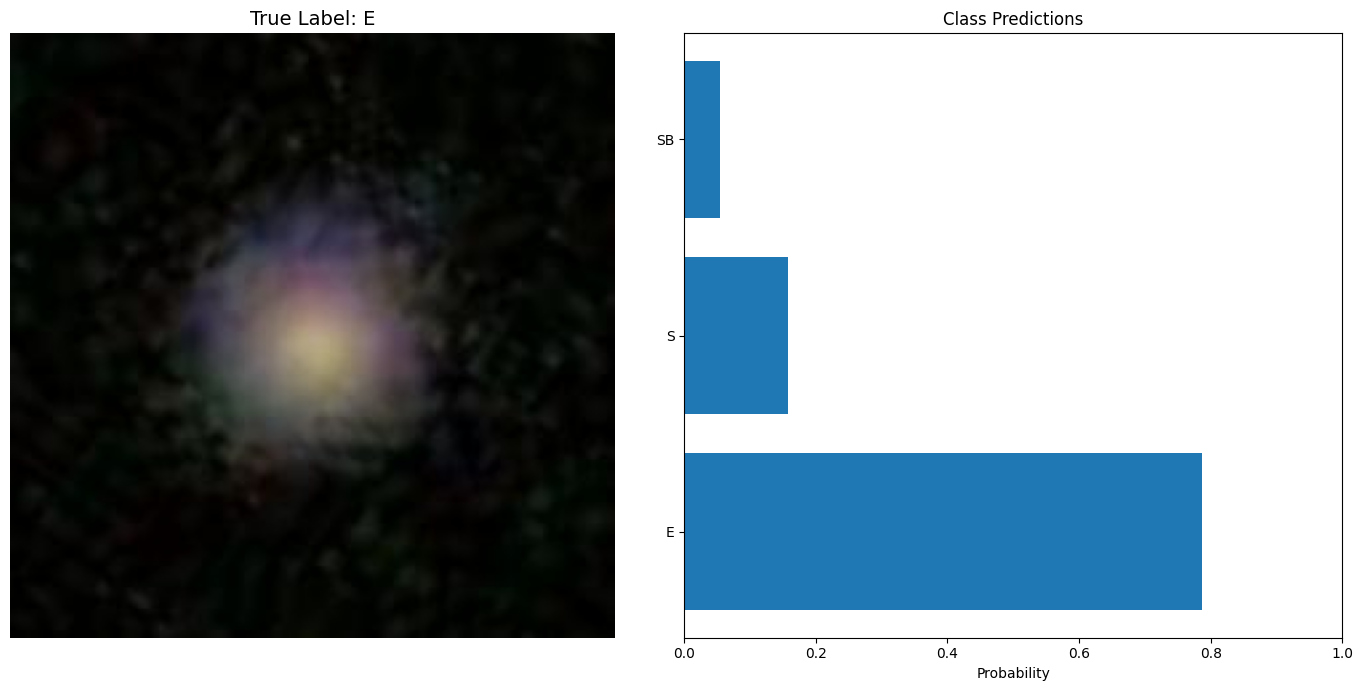

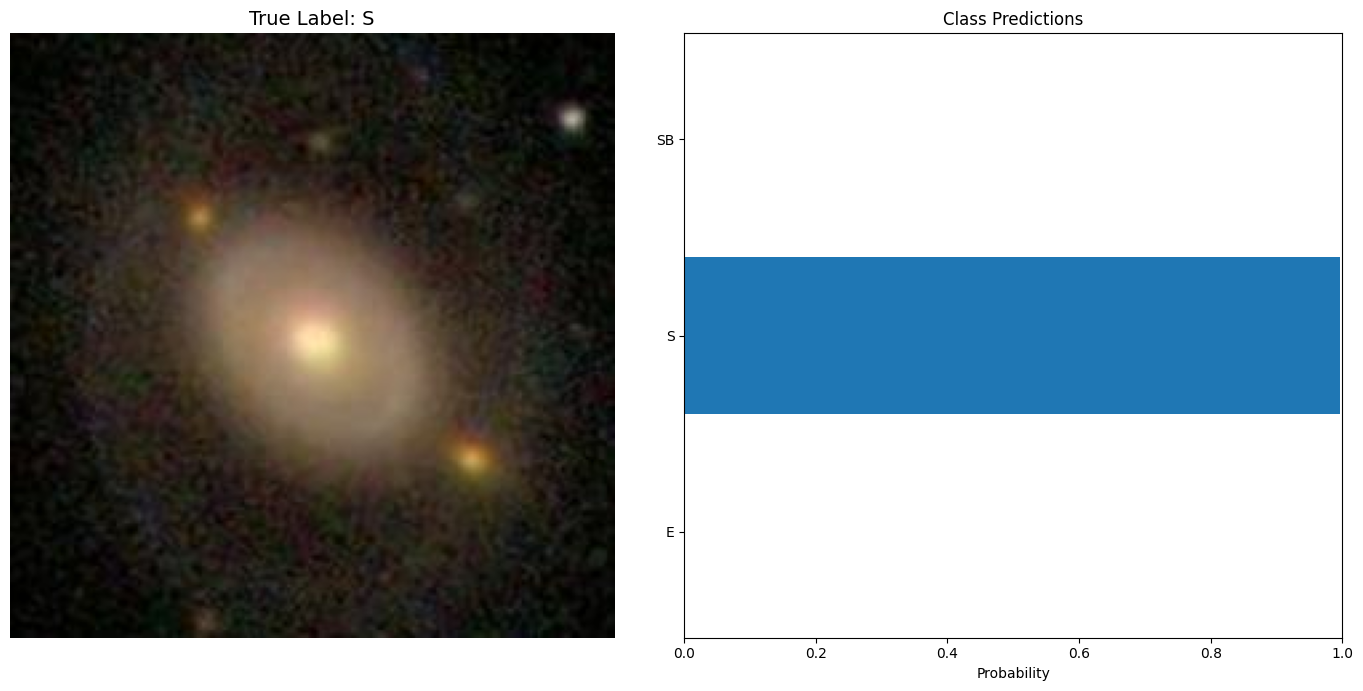

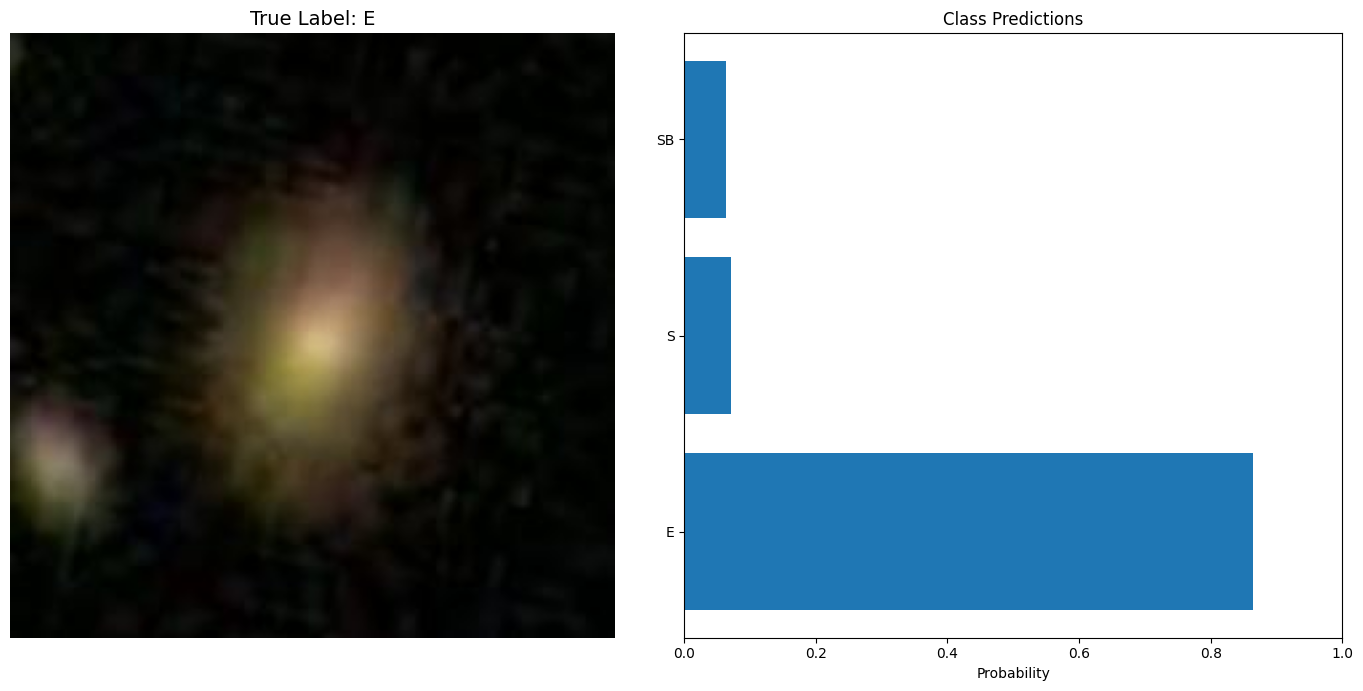

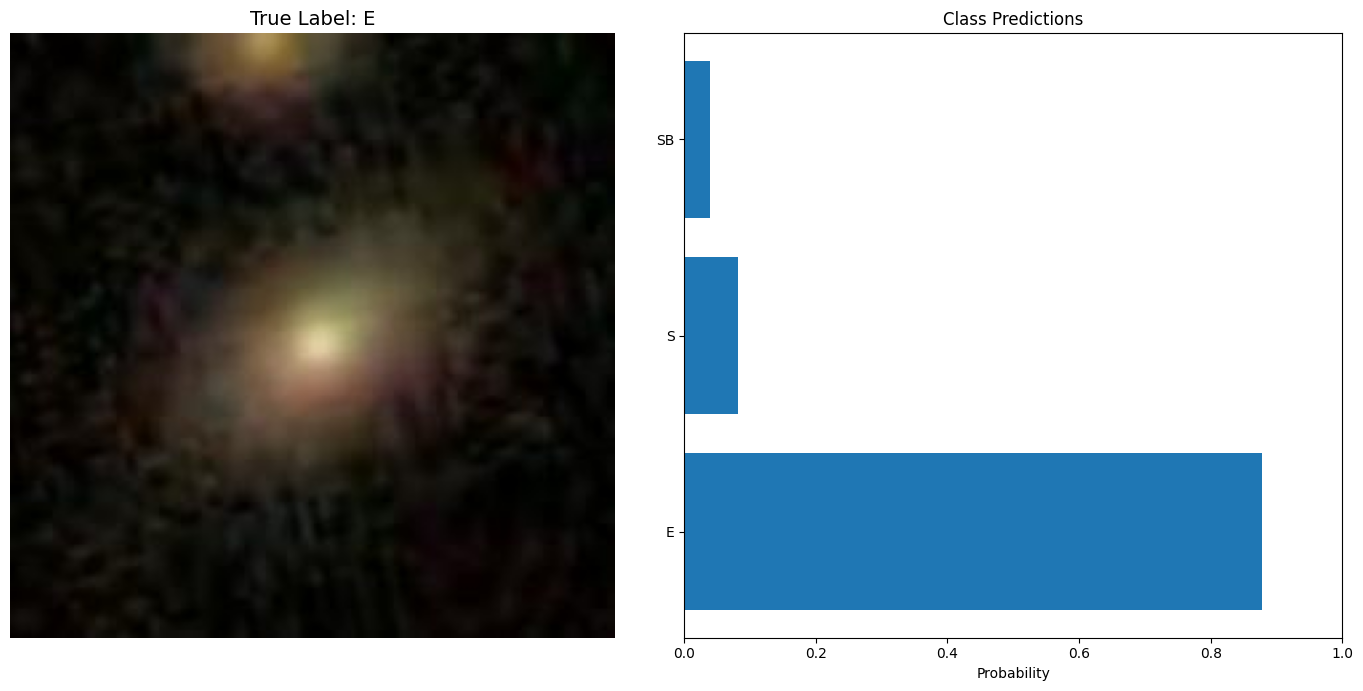

In [ ]:
# see how model performs on a set of 10 test images

# glob allows us to find files matching a specific pattern
from glob import glob
test_images = glob('/content/dataset/images_E_S_SB_227x227_a_03_test/*/*')
# select 10 random test images
test_example_images = np.random.choice(test_images, 10)
# apply our same functions for preprocessing, predicting(passing into model), and calc probabilities
for example in test_example_images:
  true_label = extract_label_from_path(example)
  original_image, image_tensor = preprocess_image(example, transform)
  probabilities = predict(model, image_tensor, device)
  class_names = list(target_to_class.values())
  # visualize the probabilities for each class(E, S, SB) to see how well model predicts
  visualize_predictions(original_image, probabilities, class_names, true_label)




# Pass in Test Dataset and Evaluate Accuracy of Model

In [ ]:
# finally, calculate the accuracy of the model on the test dataset
# look at predictions and compare it to true label
# will use sklearn.metrics accuracy_score
from sklearn.metrics import accuracy_score

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc = "Testing loop"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities_tensor = torch.nn.functional.softmax(outputs, dim=1)
        # get the index of the label/class with the maximum probability for each image in the tensor
        predictions = torch.argmax(probabilities_tensor, dim = 1)
       # store predictions(predicted labels)
        all_predictions.extend(predictions.cpu().numpy())
       # store the true labels
        all_labels.extend(labels.cpu().numpy())

# function to compare predicted labels to true labels and return an accuracy
accuracy = accuracy_score(all_labels, all_predictions)

print(f"Test Accuracy: {accuracy:.2%}")

Testing loop:   0%|          | 0/419 [00:00<?, ?it/s]

Test Accuracy: 86.64%


In [ ]:
# save the model to a file to use in our frontend
# Save the model's state dictionary
model_save_path = "galaxy_classifier.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to galaxy_classifier.pth
